In [1]:
# importing all the libraries needed 
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
sns.set_style("whitegrid")
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error

#For date time functions
from datetime import datetime
from datetime import timedelta
import math

# Importing the most popular regression libraries.
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, ridge_regression, Lasso, SGDRegressor, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn import model_selection, preprocessing
%matplotlib inline
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.utilities import regressor_coefficients
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import numpy as np
import itertools
import logging 
from fbprophet import Prophet
logging.getLogger('fbprophet').setLevel(logging.ERROR)
from tqdm import tqdm
from dask.distributed import Client

Importing plotly failed. Interactive plots will not work.


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns毎に処理
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
train = './data/train_data.csv'
test = './data/test_data.csv'

df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

#df = pd.concat([df_train, df_test])

In [4]:
df_train = df_train.sort_values(by = ['id','mes'])
df_test = df_test.sort_values(by = ['id','mes'])

In [46]:
df_train

,id,mes,tipo_ban,tipo_seg,categoria,tipo_com,tipo_cat,tipo_cli,VAR1_sum,VAR1_prom,...,VAR27_sum,VAR27_prom,VAR27_trx,VAR28_sum,VAR28_prom,VAR28_trx,VAR29_prom,VAR29_ratio,VAR30_sum,target_mes
71848,0000f07b1e0d,202004,BAN2,PROD4,V2,COM2,RUBRO9,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.97
72030,0000f07b1e0d,202005,BAN2,PROD4,V2,COM2,RUBRO9,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.42
71970,0000f07b1e0d,202006,BAN2,PROD4,V2,COM2,RUBRO9,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.69
71784,0000f07b1e0d,202007,BAN2,PROD4,V2,COM2,RUBRO9,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.61
71592,0000f07b1e0d,202008,BAN2,NO PROD3,V3,COM4,RUBRO9,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248794,ffff29fb6d8f,202012,BAN1,PROD1,V6,COM2,RUBRO2,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.53
247974,ffff29fb6d8f,202101,BAN1,PROD1,V6,COM2,RUBRO2,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,10.97
247604,ffff29fb6d8f,202102,BAN1,PROD1,V6,COM2,RUBRO2,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,20767.0,0.010,NaN,9.31
247536,ffff29fb6d8f,202103,BAN1,PROD1,V2,COM2,RUBRO2,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.25


In [58]:
# Dejamos fuera PYMEs con muy pocos registros de venta mensuales

df_train = df_train.groupby('id').filter(lambda x: len(x) > 2)

In [59]:
df_testnotintrain = df_test[~(df_test['id'].isin(df_train['id']) )].reset_index(drop=True)
print(len(df_testnotintrain.id.unique()))

11281


In [60]:
newtest = df_test[df_test['id'].isin(df_testnotintrain.id.unique()) == False]

In [61]:
df_trainnotintest = df_train[~(df_train['id'].isin(df_test['id']) )].reset_index(drop=True)
print(len(df_trainnotintest.id.unique()))

10154


In [62]:
newtrain = df_train[df_train['id'].isin(df_trainnotintest.id.unique()) == False]

In [6]:
#newtrain = pd.merge(df_train,df_test, on=['id'],how='left')
#newtest = pd.merge(df_train,df_test, on=['id'],how='right')

In [66]:
custX = newtrain.id.unique()
custY = newtest.id.unique()
print(len(custX))
print(len(custY))


21449
21449


In [67]:
df_train=newtrain.sort_values(by = ['id','mes'])
df_test=newtest.sort_values(by = ['id','mes'])

In [68]:
df_test['id_original'] = df_test['id']

In [69]:
df_test

,id,mes,tipo_ban,tipo_seg,categoria,tipo_com,tipo_cat,tipo_cli,VAR1_sum,VAR1_prom,...,VAR27_sum,VAR27_prom,VAR27_trx,VAR28_sum,VAR28_prom,VAR28_trx,VAR29_prom,VAR29_ratio,VAR30_sum,id_original
10315,0000f07b1e0d,202105,BAN2,NO PROD3,V5,COM4,RUBRO9,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000f07b1e0d
10239,0000f07b1e0d,202106,BAN2,NO PROD3,V5,COM4,RUBRO9,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000f07b1e0d
10365,0000f07b1e0d,202107,BAN2,NO PROD3,V5,COM4,RUBRO9,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000f07b1e0d
10376,0000f07b1e0d,202108,BAN2,NO PROD3,V5,COM4,RUBRO9,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000f07b1e0d
60818,0002aaf9b95c,202105,BAN1,PROD1/PROD2,V6,COM3,RUBRO3,CLI1,NaN,NaN,...,1158927.387,579463.548,2.0,NaN,NaN,NaN,1782565.000,0.261,NaN,0002aaf9b95c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35422,ffff29fb6d8f,202105,BAN1,PROD1,V2,COM2,RUBRO2,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,147693.000,0.074,NaN,ffff29fb6d8f
35471,ffff29fb6d8f,202106,BAN1,PROD1,V6,COM2,RUBRO2,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1127485.833,0.564,NaN,ffff29fb6d8f
35531,ffff29fb6d8f,202107,BAN1,PROD1,V6,COM2,RUBRO2,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,820455.500,0.410,NaN,ffff29fb6d8f
35433,ffff29fb6d8f,202108,BAN1,PROD1,V6,COM2,RUBRO2,CLI1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1495735.714,0.748,NaN,ffff29fb6d8f


In [70]:
# Form Date, Year, Month, Week, Day
def split(data):
    data['Date'] = pd.to_datetime(data['mes'],format='%Y%m')
    data['Year'] = data['Date'].dt.year
    data['Month']= data['Date'].dt.month
    return data

df_train=split(df_train)
df_test=split(df_test)

In [71]:

def labelrecoded(df):
    for f in df.columns:
        if df[f].dtype=='object' and f !='id_original':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(df[f].values)) 
            df[f] = lbl.transform(list(df[f].values))
    return df

In [72]:
df_train = labelrecoded(df_train)
df_test = labelrecoded(df_test)

In [73]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 122.90 Mb (58.6% reduction)
Mem. usage decreased to 21.82 Mb (57.6% reduction)


In [74]:
df_test

,id,mes,tipo_ban,tipo_seg,categoria,tipo_com,tipo_cat,tipo_cli,VAR1_sum,VAR1_prom,...,VAR28_sum,VAR28_prom,VAR28_trx,VAR29_prom,VAR29_ratio,VAR30_sum,id_original,Date,Year,Month
10315,0,202105,1,3,3,3,20,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0000f07b1e0d,2021-05-01,2021,5
10239,0,202106,1,3,3,3,20,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0000f07b1e0d,2021-06-01,2021,6
10365,0,202107,1,3,3,3,20,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0000f07b1e0d,2021-07-01,2021,7
10376,0,202108,1,3,3,3,20,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0000f07b1e0d,2021-08-01,2021,8
60818,1,202105,0,6,4,2,14,0,NaN,NaN,...,NaN,NaN,NaN,1.782565e+06,0.260986,NaN,0002aaf9b95c,2021-05-01,2021,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35422,21448,202105,0,5,0,1,11,0,NaN,NaN,...,NaN,NaN,NaN,1.476930e+05,0.073975,NaN,ffff29fb6d8f,2021-05-01,2021,5
35471,21448,202106,0,5,4,1,11,0,NaN,NaN,...,NaN,NaN,NaN,1.127486e+06,0.563965,NaN,ffff29fb6d8f,2021-06-01,2021,6
35531,21448,202107,0,5,4,1,11,0,NaN,NaN,...,NaN,NaN,NaN,8.204555e+05,0.409912,NaN,ffff29fb6d8f,2021-07-01,2021,7
35433,21448,202108,0,5,4,1,11,0,NaN,NaN,...,NaN,NaN,NaN,1.495736e+06,0.748047,NaN,ffff29fb6d8f,2021-08-01,2021,8


In [75]:
X = df_train[['id','mes','Date',  'tipo_seg',   'tipo_com', 'tipo_cat','tipo_ban', 
                    'VAR11_sum',  'VAR12_sum',  'VAR13_sum', 'target_mes']]
y =  df_test[['id','id_original','mes','Date',  'tipo_seg',  'tipo_com', 'tipo_cat', 'tipo_ban',  
                    'VAR11_sum',  'VAR12_sum',  'VAR13_sum'  ]]

#varsX = ['id','tipo_ban', 'VAR13_sum', 'VAR11_sum', 'tipo_seg', 'tipo_com', 'VAR12_sum', 'tipo_cat','target_mes','mes']

In [76]:

X['VAR11_sum'] = X['VAR11_sum'].fillna(0)
X['VAR12_sum'] = X['VAR12_sum'].fillna(0)
X['VAR13_sum'] = X['VAR13_sum'].fillna(0)

y['VAR11_sum'] = y['VAR11_sum'].fillna(0)
y['VAR12_sum'] = y['VAR12_sum'].fillna(0)
y['VAR13_sum'] = y['VAR13_sum'].fillna(0)



#X['nDate'] = pd.to_numeric(df_train['Date'])

In [77]:
regressors = ['categoria',  'tipo_seg',  'tipo_ban',  'tipo_com', 'tipo_cat',  'tipo_cli', 
              'VAR21_sum',  'VAR22_sum',  'VAR14_sum',  'VAR15_sum',  'VAR12_sum', 'VAR11_sum']

In [78]:
custX = X['id'].unique()
custy = y['id'].unique()

df = X[(X['id']==custX[0])] 
print(len(custX))
print(len(custy))


21449
21449


In [79]:
def mae(y,yhat):
    return np.sum(np.absolute(y - yhat)) / len(y)

In [80]:


def runProphet(df=False, df2=False, parameters=False):

    model=Prophet( 
                  #growth = 'linear',
                  #yearly_seasonality=4,
                  **parameters
                  )

    periods = df2.shape[0]

 

    regressors = [ 'tipo_seg',  'tipo_com', 'tipo_cat', 'tipo_ban',  
                  'VAR11_sum',  'VAR12_sum',  'VAR13_sum']
    for regressor in regressors:
        model.add_regressor(name = regressor, 
                            #mode= 'multiplicative',
                            #prior_scale = 10,
                            standardize = 'auto')

    tserie = df.rename(columns = {'Date': 'ds', 'target_mes': 'y'}, inplace = False)

    model.fit(tserie)
    #future = model.make_future_dataframe(periods=periods,freq = 'M',include_history =True) 
    new = df2.rename(columns = {'Date': 'ds'}, inplace = False)
    tserie=tserie.append(new)
    tserie['floor'] = 0
    forecast = model.predict(tserie)
    forecast.loc[forecast['yhat'] < 0, 'yhat'] = 0
    return model, forecast 



In [82]:

def outliers(df7):

 
    df7 = df7.rename(columns = {'Date': 'ds', 'target_mes': 'y'}, inplace = False)
    df7 = df7.reset_index()
    df7['ds'] = pd.to_datetime(df7['ds'])
    model = Prophet(seasonality_mode='multiplicative',
              yearly_seasonality=6,
              seasonality_prior_scale=.01,
              changepoint_prior_scale=.01,
              interval_width=.90)
    model.fit(df7)
    forecast = model.predict()
    forecast['ds'] = pd.to_datetime(forecast['ds'])

    df8 = pd.DataFrame()
    df8= df7[(df7['y'] > forecast['yhat_lower']) &
             (df7['y'] < forecast['yhat_upper'])

       ]
    return df8




In [88]:
def make_submission(y, preds):

    submission = pd.DataFrame(columns = ['id_original','mes', 'yhat'])
    y = y.reset_index(drop=True)
    submission.id_original = y.id_original
    submission.mes = y.mes
    submission.loc[:,'yhat'] = pd.Series(preds)
    fsub = './data/sub.csv'
    submission.to_csv(fsub,header=['id', 'mes', 'target_mes'])
    

In [84]:
customers15 = ['4c280185bf57',  '5c3bbbb8ec67',  '9f31c3d9d9bb',  '2706747f4e32',  '122ebc8338af',  'dffb8a651fe3',  'a1a40e7cddb2',
               '5f6af88bbfcc',  '1b15a12030a5',  'a8807268636e',  'dcfbd17ce176',  '4663650fc699',  '405403edb790',  '1967a7c27330',  
               '59dd75fb210a']

In [85]:
testcustomers = list(map(lambda cust: y[y['id_original'] == cust]['id'].unique()[0],[ cust for cust in customers15]))

In [86]:
testcustomers

[6353,
 7684,
 13353,
 3189,
 1480,
 18720,
 13566,
 7960,
 2222,
 14138,
 18473,
 5840,
 5330,
 2091,
 7501]

In [ ]:
customers = X.id.unique()

custX = X['id'].unique()
custy = y['id'].unique()

lmae = []

#params = {'seasonality_mode' : 'multiplicative'}

params = {}
preds = []

for i in tqdm(customers):
    df = X[(X['id']==custX[i])] 
    df2 = y[(y['id']==custy[i])]
 
  
    df = outliers(df)
    shape = df.shape[0]

    model, tseries = runProphet(df, df2,params)

    y_train = tseries[:shape]
    forecast = tseries[shape:]
    x = mae(y_train['yhat'],df['y'])
    lmae.append(x)
    #lforecast.extend(forecast['yhat'])

    df2['yhat'] = forecast['yhat']

    #fig = model.plot(tseries)
    #add_changepoints_to_plot(fig.gca(),model,tseries,cp_linestyle='')
    #fig2 = model.plot_components(tseries)
    #plt.show()
    #regressor_coefficients(model)
    preds.extend(forecast['yhat'].values.tolist())

print("MAE : ", np.sum(lmae)/len(lmae))
make_submission(y, preds)



In [222]:
make_submission(y, preds)

In [90]:


param_grid = {'changepoint_prior_scale' : [0.5,0.1,0.01,0.001],
              'seasonality_prior_scale' : [10.0, 1.0, 0.1, 0.01],
              'seasonality_mode' : ['additive','multiplicative']
              }

all_params = [dict(zip(param_grid.keys(), value))
              for value in itertools.product(
                  *param_grid.values()
              )
             ]
mae_values = []
             

In [ ]:


#df = df.rename(columns = {'Date': 'ds', 'target_mes': 'y'}, inplace = False)

df = X[(X['id']==custX[0])] 
df2 = y[(y['id']==custy[0])]

df = outliers(df)

mae_values = []
for params in tqdm(all_params):
    #model = Prophet(yearly_seasonality=4,growth='linear', **params).fit(df)
    
    model, _  = runProphet(df, df2, params)
    client = Client()
    df_cv = cross_validation(model, 
                         horizon = '30 days',
                         period = '200 days',
                         initial = '300 days',
                         parallel  = 'dask')
    df_p = performance_metrics(df_cv, rolling_window=1)
    mae_values.append(df_p['mae'].values[0])
                         

In [110]:
results = pd.DataFrame(all_params)
results['mae'] = mae_values
results.head()






,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,mae
0,0.5,10.0,additive,93.417367
1,0.5,10.0,multiplicative,94.432408
2,0.5,1.0,additive,93.417367
3,0.5,1.0,multiplicative,94.432408
4,0.5,0.1,additive,93.417367


In [111]:
best_params = all_params[np.argmin(mae_values)] 
print(best_params)


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


100%|██████████| 1/1 [00:25<00:00, 25.09s/it]


35.42906032907128


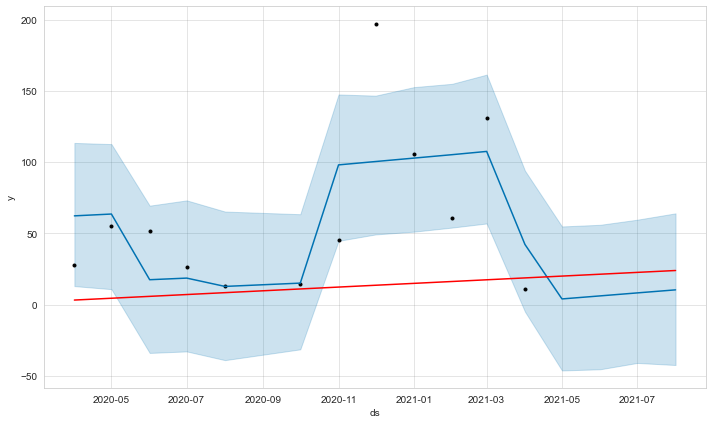

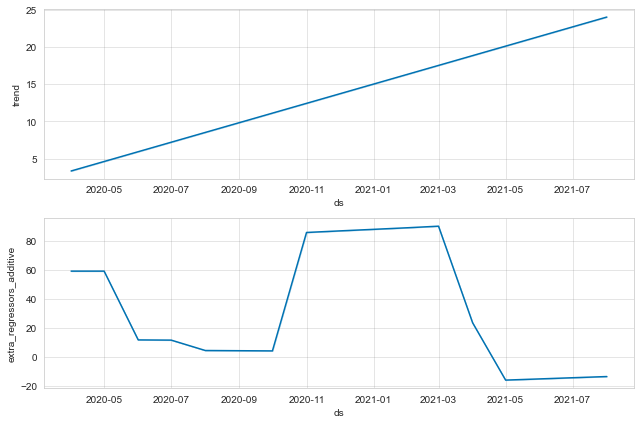

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,categoria,additive,2.666667e+00,4.028938e+01,4.028938e+01,4.028938e+01
1,tipo_seg,additive,6.666667e+00,2.149929e+00,2.149929e+00,2.149929e+00
2,tipo_ban,additive,0.000000e+00,1.272679e-01,1.272679e-01,1.272679e-01
3,tipo_com,additive,2.333333e+00,-1.182461e+01,-1.182461e+01,-1.182461e+01
4,tipo_cat,additive,0.000000e+00,2.545359e+00,2.545359e+00,2.545359e+00
5,tipo_cli,additive,0.000000e+00,8.612246e-10,8.612246e-10,8.612246e-10
6,VAR21_sum,additive,0.000000e+00,8.611713e-10,8.611713e-10,8.611713e-10
7,VAR22_sum,additive,0.000000e+00,8.612215e-10,8.612215e-10,8.612215e-10
8,VAR14_sum,additive,0.000000e+00,8.609525e-10,8.609525e-10,8.609525e-10
9,VAR15_sum,additive,0.000000e+00,8.612989e-10,8.612989e-10,8.612989e-10


In [113]:
lmae = []
for i in tqdm(customers[:1]):
    df = X[(X['id']==custX[i])] 
    df2 = y[(y['id']==custy[i])]
    shape = df.shape[0]

    df = outliers(df)

    model, tseries = runProphet(df, df2,best_params)

    y_train = tseries[:shape]
    forecast = tseries[shape:]
    x = mae(y_train['yhat'],df['y'])
    lmae.append(x)
 


print(np.sum(lmae)/len(lmae))

fig = model.plot(tseries)
add_changepoints_to_plot(fig.gca(),model,tseries,cp_linestyle='')
fig2 = model.plot_components(tseries)
plt.show()
regressor_coefficients(model)

  

In [ ]:
customers = X.id.unique()
custX = X.id.unique()


lmae = []
params={}

for i in tqdm(customers[:5]):
    df = X[(X['id']==custX[i])] 
    df2 = y[(y['id']==custy[i])]
    shape = df.shape[0]

    # model, tseries = runProphet(df, df2, len(df2),{})

    mae_values = []
    for params in all_params:
        model, _  = runProphet(df, df2, len(df2), params)
        df_cv = cross_validation(model, 
                         horizon = '30 days',
                         period = '200 days',
                         initial = '300 days',
                         parallel  = 'dask')
        df_p = performance_metrics(df_cv, rolling_window=1)
        mae_values.append(df_p['mae'].values[0])
        best_params = all_params[np.argmin(mae_values)] 
                         
    model, tseries = runProphet(df, df2, len(df2),best_params)

    y_train = tseries[:shape]
    forecast = tseries[shape:]
    x = mae(y_train['yhat'],df['target_mes'])
    print(x)
    lmae.append(x)


print(np.sum(lmae)/len(lmae))